# Projet 5 - Segmentez les comportements de clients - Nettoyage et exploration

### 1.Imports des librairies et configurations diverses

#### 1.1.Configuration de l'environnement

In [0]:
# !pip install --upgrade numpy

In [0]:
# !pip install --upgrade pandas

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


#### 1.2.Librairies

In [0]:
# Import the `pandas` library as `pd`
import pandas as pd
# Import pyplot from matplotlib as plt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
# Import the `numpy` library as `np`
import numpy as np

import seaborn as sns

import os
import re
import datetime as dt

# Scikit-learn Packages
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

# from sklearn.dummy import DummyClassifier
# from sklearn.cluster import KMeans
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC, LinearSVC

# from sklearn.metrics import silhouette_samples, silhouette_score 
# from sklearn.metrics import accuracy_score, confusion_matrix

from joblib import dump, load
from mpl_toolkits.mplot3d import Axes3D




#### 1.3.Contexte de mémoire

In [0]:
# cache directory for joblib objects
folder = "/content/gdrive/My Drive/Colab Notebooks/joblib_memmap/"
try:
    os.mkdir(folder)
except FileExistsError:
    pass

### 2.Chargement de la base

In [0]:
raw_data = pd.read_excel('/content/gdrive/My Drive/Colab Notebooks/Base/Feed/Online Retail.xlsx')

In [7]:
raw_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### 3.Exploration

On constate dans un premier temps que la base comprend les champs:
* InvoiceNo - va permettre de regrouper les observations par achat
* StockCode et Description - décrivent le produit acheté. Va-t-on pouvoir définir des catégories de produits et les utiliser dans la classification des clients? Le nombre de stockCode différent peut aussi être un critère utilisable pour définir si un client regroupe ses achats (beaucoup d'items à la fois) ou réalise beacoup d'achats de petites quantités
* Quantity - utilisable pour calculer le montant total d'achat, et pour définir la taille du paniers en nombre total d'items
* InvoiceDate - champs de type DateTime, permet de travailler sur les features temporelles (ancienneté, date de dernier achat, temps moyen entre achats, jours et heure d'achat préférentiels,...)
* UnitPrice - utilisable pour comparer les gammes de prix des produits achetés, calculer le prix total du panier, ...
* CustomerID - permet d'identifier chaque client
* Country - utilisable pour différencier des habitudes d'achat selon la nationalité  du client?

https://archive.ics.uci.edu/ml/datasets/online+retail

Attribute Information:

InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. 
StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. 
Description: Product (item) name. Nominal. 
Quantity: The quantities of each product (item) per transaction. Numeric.	
InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated. 
UnitPrice: Unit price. Numeric, Product price per unit in sterling. 
CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. 
Country: Country name. Nominal, the name of the country where each customer resides.

In [8]:
raw_data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [9]:
# Taux de remplissage des colonnes
taux_col = []
nb_obs = len(raw_data)
taux = 0
for col in range(len(raw_data.columns)):
    taux = raw_data[raw_data.columns[col]].count()/nb_obs*100
    taux_col.append(taux)
    print(col, ":\t", raw_data.columns[col], "\t", taux)

0 :	 InvoiceNo 	 100.0
1 :	 StockCode 	 100.0
2 :	 Description 	 99.73168926886248
3 :	 Quantity 	 100.0
4 :	 InvoiceDate 	 100.0
5 :	 UnitPrice 	 100.0
6 :	 CustomerID 	 75.0733056657114
7 :	 Country 	 100.0


On constate que les descriptifs de tous les produits ne sont pas remplis. A voir si l'on utilise ce champs.

#### 3.1.Identifiants client manquant

il manque un quart des identifiants client. On va essayer de les retrouver à partir des numéros de facture. Pour cela, on va dresser la liste des InvoiceNo pour lesquels CustomerID est absent. On va ensuite compter le nombre de customer ID pour chaque InvoiceNo dans le jeu de données complet. Si ce nombre est 1, on le duplique à toutes les lignes de l'Invoice correspondant, si c'est 0, on ne pourra pas le retrouver. Si on a plusieurs ID, il y a une erreur, et l'invoice n'est pas utilisable.

On commence par lister les n° de facture pour lesquels l'ID du client n'est pas renseigné:

In [10]:
list_Inv_no = raw_data[raw_data['CustomerID'].isna()].InvoiceNo.unique()
print(len(list_Inv_no))

3710


Il y a 3710 factures concernées. pour chaque n° de facture, on liste les Id client rencontrés.

In [0]:
for inv_no in list_Inv_no:
  list_ID = raw_data[(raw_data['InvoiceNo'] == inv_no)].CustomerID.unique()

In [12]:
list_ID

array([nan])

list_ID est vide. Cela signifie que l'on ne peut associer les factures pour lesquelles CustomerId est vide à aucun compte client.

Quand Customer ID est n'est pas saisi, il est possible que ce soit des clients qui passent une unique commande sans créer de compte client(certains sites marchands le permettent): il n'y aurait dans ce cas pas d'ID client créé / associé à la commande.

#### 3.2.Frais et commissions divers

Certains StockCode ne correspondent pas à des items commandés par les clients. il s'agit de commissions et frais (transport), remises, échantillons. Nous allons supprimer ces éléments du jeu de données car ils ne correspondent pas aux éléments que nous souhaitons analyser.

In [13]:
raw_data[(raw_data['StockCode'] == 'D')].head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
9038,C537164,D,Discount,-1,2010-12-05 13:21:00,29.29,14527.0,United Kingdom


In [14]:
raw_data[(raw_data['StockCode'] == 'S')].head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
14436,C537581,S,SAMPLES,-1,2010-12-07 12:03:00,12.95,NaN,United Kingdom
14437,C537581,S,SAMPLES,-1,2010-12-07 12:03:00,52.00,NaN,United Kingdom


In [15]:
raw_data[(raw_data['StockCode'] == 'AMAZONFEE')].head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
14514,C537600,AMAZONFEE,AMAZON FEE,-1,2010-12-07 12:41:00,1.00,NaN,United Kingdom
15016,C537630,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:04:00,13541.33,NaN,United Kingdom


In [16]:
raw_data[(raw_data['StockCode'] == 'M')].head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
2239,536569,M,Manual,1,2010-12-01 15:35:00,1.25,16274.0,United Kingdom
2250,536569,M,Manual,1,2010-12-01 15:35:00,18.95,16274.0,United Kingdom


In [17]:
raw_data[(raw_data['StockCode'] == 'POST')].head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.0,12583.0,France
386,536403,POST,POSTAGE,1,2010-12-01 11:27:00,15.0,12791.0,Netherlands


In [18]:
raw_data[(raw_data['StockCode'] == 'DOT')].head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1814,536544,DOT,DOTCOM POSTAGE,1,2010-12-01 14:32:00,569.77,NaN,United Kingdom
3041,536592,DOT,DOTCOM POSTAGE,1,2010-12-01 17:06:00,607.49,NaN,United Kingdom


In [19]:
raw_data[(raw_data['StockCode'] == 'CRUK')].head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
317508,C564763,CRUK,CRUK Commission,-1,2011-08-30 10:49:00,1.60,14096.0,United Kingdom
324023,C565382,CRUK,CRUK Commission,-1,2011-09-02 15:45:00,13.01,14096.0,United Kingdom


In [20]:
raw_data[(raw_data['CustomerID'] == 14096.0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
317502,564764,16207B,PINK HEART RED HANDBAG,1,2011-08-30 10:49:00,2.46,14096.0,United Kingdom
317503,564764,16225,RATTLE SNAKE EGGS,1,2011-08-30 10:49:00,3.29,14096.0,United Kingdom
317504,564764,16254,TRANSPARENT ACRYLIC TAPE DISPENSER,1,2011-08-30 10:49:00,1.63,14096.0,United Kingdom
317505,564764,84249A,"GREETING CARD,SQUARE, DOUGHNUTS",1,2011-08-30 10:49:00,0.83,14096.0,United Kingdom
317506,564764,84659A,WHITE TRAVEL ALARM CLOCK,2,2011-08-30 10:49:00,1.23,14096.0,United Kingdom
317507,564764,DOT,DOTCOM POSTAGE,1,2011-08-30 10:49:00,11.17,14096.0,United Kingdom
317508,C564763,CRUK,CRUK Commission,-1,2011-08-30 10:49:00,1.60,14096.0,United Kingdom
323984,565383,20718,RED RETROSPOT SHOPPER BAG,1,2011-09-02 15:45:00,2.46,14096.0,United Kingdom
323985,565383,20733,GOLD MINI TAPE MEASURE,2,2011-09-02 15:45:00,0.83,14096.0,United Kingdom
323986,565383,21914,BLUE HARMONICA IN BOX,1,2011-09-02 15:45:00,2.46,14096.0,United Kingdom


A chaque commande du client 14096, il y a une commission CRUK déduite, un DOTCOM POSTAGE ajouté.

#### 3.3.Annulations d'items
Les numéros de commande commençant par C correspondent à une annulation. Voyons si on retrouve la commande originale, afin de mettre à jour les informations  de la commande et du client correspondants.

Note: Serait-il intéressant de créer un indicateur du taux d'annulation d'un client?

Commençons par trier les lignes par ordre chronologique, afin de bien avoir la temporalité des opérations

In [0]:
raw_data.sort_values(by=['InvoiceDate', 'CustomerID', 'StockCode'], inplace=True)
raw_data.reset_index(drop=True,inplace=True)

On regarde l'exemple d'un item ayant des annulations.

In [22]:
raw_data[(raw_data['StockCode'] == 22244)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1113,536527,22244,3 HOOK HANGER MAGIC GARDEN,12,2010-12-01 13:04:00,1.95,12662.0,Germany
1977,C536548,22244,3 HOOK HANGER MAGIC GARDEN,-4,2010-12-01 14:33:00,1.95,12472.0,Germany
5980,536876,22244,3 HOOK HANGER MAGIC GARDEN,2,2010-12-03 11:36:00,4.21,NaN,United Kingdom
9388,537201,22244,3 HOOK HANGER MAGIC GARDEN,12,2010-12-05 14:19:00,1.95,12472.0,Germany
11092,537240,22244,3 HOOK HANGER MAGIC GARDEN,1,2010-12-06 10:08:00,4.21,NaN,United Kingdom
13538,537434,22244,3 HOOK HANGER MAGIC GARDEN,1,2010-12-06 16:57:00,4.21,NaN,United Kingdom
14465,537594,22244,3 HOOK HANGER MAGIC GARDEN,12,2010-12-07 12:28:00,1.95,12647.0,Germany
16652,537666,22244,3 HOOK HANGER MAGIC GARDEN,1,2010-12-07 18:36:00,4.21,NaN,United Kingdom
19038,537828,22244,3 HOOK HANGER MAGIC GARDEN,12,2010-12-08 14:43:00,1.95,15680.0,United Kingdom
20945,538071,22244,3 HOOK HANGER MAGIC GARDEN,1,2010-12-09 14:09:00,4.21,NaN,United Kingdom


Il y a une annulation faite par le client 12472 le 01/12/2010. Or nous n'avons pas l'opération précédente, qui comporte la quantité sur laquelle nous devons annuler la quantité. On va procéder de la façon suivante:
on rectifie la quantité réelle commandée en soustrayant la quantié d'une annulation à la commande précédente (même StockCode, même CustomerID) si elle fait partie du jeu de données.

Note: On observe également que le prix varie en fonction du client: ceux qui ont un ID payent 1.95, alors que ceux qui n'ont pas d'ID payent 4.21 puis 4.13 (il a du y avoir une baisse du prix).

### 4.Nettoyage

#### 4.1.Nettoyage pour travail de modélisation de la première phase.

In [0]:
liste_supp = ['AMAZONFEE', 'D', 'DOT', 'M', 'BANK CHARGES', 'CRUK', 'POST']

In [0]:
df_step1 = raw_data[~raw_data['StockCode'].isin(liste_supp)]

In [0]:
# df_step2 = df_step1[df_step1['Quantity'] > 0]
df_step2 = df_step1

In [0]:
df_step3 = df_step2[df_step2['UnitPrice'] > 0]

In [0]:
df_step4 = df_step3[pd.notnull(df_step3['CustomerID'])]

In [28]:
df_step4.describe()

,Quantity,UnitPrice,CustomerID
count,405013.000000,405013.000000,405013.000000
mean,12.068763,2.916971,15295.017755
std,248.426037,4.516072,1710.211905
min,-80995.000000,0.001000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,5.000000,1.950000,15159.000000
75%,12.000000,3.750000,16794.000000
max,80995.000000,649.500000,18287.000000


In [0]:
df_feat = df_step4.copy()
df_feat.reset_index(drop=True, inplace=True)
# df_feat = raw_data.copy()

#### 4.2.Items annulés
On récupère la liste des items annulés dans un dataframe.

In [0]:
dfC = df_feat.loc[df_feat['InvoiceNo'].str.startswith('C', na=False)]

In [31]:
dfC.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
152,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
233,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548.0,United Kingdom
234,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
235,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


In [32]:
dfC.shape

(8540, 8)

In [0]:
# pour chaque ligne de dfC:
#    sortir les cdes du même id client et même stockcode si il y en a 
#    garder le dernier, et y ajouter la somme des deux qtés (+) + (-) 
#    si on ne trouve pas de correspondance, ajouter à un df d'annulations non 
#    trouvées pour analyser

for index,row in dfC.iterrows():
  try:
    customer = row['CustomerID']
    code = row['StockCode']
    qty = row['Quantity']
  #   print(index, customer, code, qty)

  #   print(dfC[index:index+1])
  #   print(df_feat[index:index+1])

    cdes = df_feat[0:index].loc[df_feat['CustomerID'] == customer]
    cdes = cdes[cdes['StockCode'] == code]
    idx = max(cdes.index)
    df_feat.at[idx, 'Quantity'] += qty
  except:
    next

# compter annulations  par ID client:
#    - nb
#    - qté
#    - montant
# en sortir un ration intéressant (?)

In [0]:
df_feat = df_feat[df_feat['Quantity'] > 0]

In [0]:
df_feat.reset_index(drop=True, inplace=True)

### 5.Analyse univariée

Quantity :
minimum =  1
maximum =  4800
moyenne =  12.479092975127916
médiane =  5.0
mode =  0    1
dtype: int64
variance =  1749.0782362565515
ecart-type =  41.82198269160074
skewness =  30.30546636284019
kurtosis =  1838.5417940064729


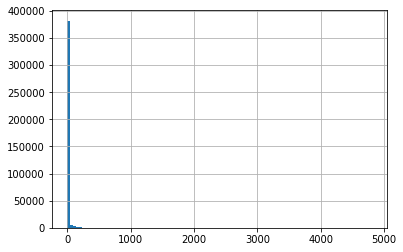

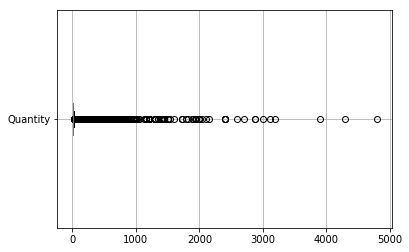

--------------------
UnitPrice :
minimum =  0.001
maximum =  649.5
moyenne =  2.8645056257340946
médiane =  1.95
mode =  0    1.25
dtype: float64
variance =  16.50071602134365
ecart-type =  4.062107337496592
skewness =  27.613198676363858
kurtosis =  2376.5613529924995


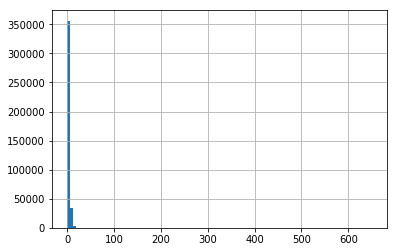

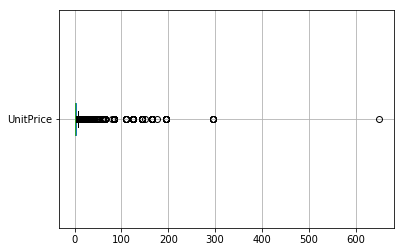

--------------------


In [36]:
#Tableau des indicateurs de tendance centrale
for col in ['Quantity','UnitPrice']:
      print(col, ":")
      print("minimum = ", df_feat[col].min())
      print("maximum = ", df_feat[col].max())        
      print("moyenne = ", df_feat[col].mean())
      print("médiane = ", df_feat[col].median())
      print("mode = ", df_feat[col].mode())
      print("variance = ",df_feat[col].var(ddof=0))
      print("ecart-type = ",df_feat[col].std(ddof=0))
      print("skewness = ",df_feat[col].skew())
      print("kurtosis = ",df_feat[col].kurtosis())
      df_feat[col].hist(bins = 100)
      plt.show()
      df_feat.boxplot(column=col, vert=False)
      plt.show()
      print("-"*20)

Quantity :


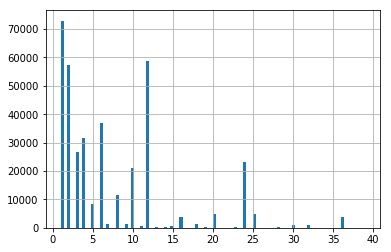

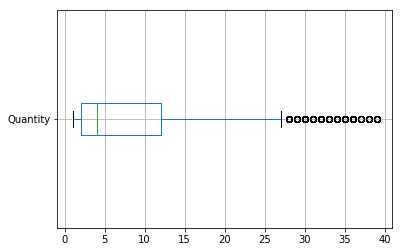

--------------------
UnitPrice :


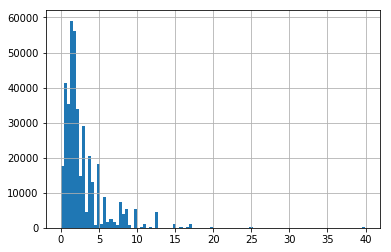

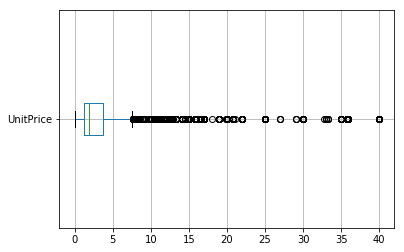

--------------------


In [37]:
#Tableau des indicateurs de tendance centrale
for col in ['Quantity','UnitPrice']:
      print(col, ":")
      df_feat[df_feat[col] < 40][col].hist(bins = 100)
      plt.show()
      df_feat[df_feat[col] < 40].boxplot(column=col, vert=False)
      plt.show()
      print("-"*20)

### 6.Séparation jeux de test et d'entrainement

On créée un jeu de test biaisé par horizon temporel (2 dernières semaines du jeu de données) pour mesurer la performance en conditions réelles: nouveaux clients après entraînement et mise en production du modèle.

In [0]:
t_split = dt.datetime(2011, 12, 7, 0, 0, 0, 0)

In [0]:
X_test_new = df_feat[df_feat['InvoiceDate'] > t_split]

In [0]:
df_feat = df_feat[df_feat['InvoiceDate'] <= t_split]

In [0]:
list_ID = df_feat.CustomerID.unique()

In [0]:
ID_train, ID_test = train_test_split(list_ID, train_size = 0.8, test_size=0.2)
# On génère le dataset d'entrainement, et celui de test

In [0]:
X_train = df_feat[df_feat['CustomerID'].isin(ID_train)]

In [0]:
X_test = df_feat[df_feat['CustomerID'].isin(ID_test)]

In [83]:
X_train.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
1,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
2,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
3,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [84]:
X_test.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
26,536370,10002,INFLATABLE POLITICAL GLOBE,48,2010-12-01 08:45:00,0.85,12583.0,France
27,536370,21035,SET/2 RED RETROSPOT TEA TOWELS,18,2010-12-01 08:45:00,2.95,12583.0,France
28,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,2010-12-01 08:45:00,0.85,12583.0,France
29,536370,21731,RED TOADSTOOL LED NIGHT LIGHT,24,2010-12-01 08:45:00,1.65,12583.0,France
30,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,24,2010-12-01 08:45:00,1.25,12583.0,France


### 7.Feature engineering

Nous allons créer les variables suivantes pour chaque ID client:
* nb_inv: Nombre de commandes( = nombre de factures)
* recency: Durée (en jours) depuis la dernière commande 
* monetary_value: Montant total dépensé par le client
* mean_qty: quantité moyenne par commande
* mean_value: montant moyen par commande
* ref_tot: nombre de références distinctes sur l'ensemble des commandes du client
* mean_ref: nombre moyen de références distinctes par commande
* up_mean: prix unitaire moyen des articles commandés

Concernant le prix unitaire moyen, il y a plusieurs interprétations possibles: 
* le prix moyen par référence  unique, sans tenir compte de la quantité de chaque référence
* le montant total divisé par le nombre total de produits (prends en considération la quantité de chaque produit)
le deuxième cas étant le rapport entre deux variables déjà créées, on privilégiera la première interprétation.


In [0]:
X_feat = X_train.copy()

#### 7.1.Création des variables
On commence par ajouter une colonne du Prix total (quantité * prix unitaire):

In [0]:
X_feat['TotalPrice'] = X_feat['Quantity'] * X_feat['UnitPrice']

In [87]:
X_feat.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,25.50
1,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,15.30
2,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
3,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


Pour déterminer le délai depuis la dernière commande, on doit définir une base (t_zero). On fixe t_zero = lendemain de la dernière commande du jeu de données.

In [0]:
X_feat['InvoiceDate'] = pd.to_datetime(X_feat['InvoiceDate'])

In [0]:
t_zero = df_feat['InvoiceDate'].max() + dt.timedelta(days=1)

In [90]:
t_zero

Timestamp('2011-12-07 17:49:00')

La "date de référence" t_zero est donc fixée au 10 décembre 2011.

In [0]:
# featTable = df_feat.groupby('CustomerID').agg({'InvoiceDate': lambda x: (t_zero - x.max()).days,
#                                               'InvoiceNo': lambda x: len(x),
#                                               'TotalPrice': lambda x: x.sum()})
# featTable['InvoiceDate'] = featTable['InvoiceDate'].astype(int)
# featTable.rename(columns={'InvoiceDate': 'recency', 
#                          'InvoiceNo': 'tot_item', 
#                          'TotalPrice': 'monetary_value'}, inplace=True)

In [0]:
# featTable.head()

In [0]:
# featTable.describe()

In [0]:
# X = rfmTable.copy()

On dresse la liste des ID client du jeu de données.

In [0]:
list_ID = sorted(X_feat.CustomerID.unique())

On créée l'ensemble des variables:

In [0]:
resultat = pd.DataFrame()

for id in list_ID:
  df_ID = X_feat[X_feat['CustomerID'] == id]
  inv_count = len(df_ID.InvoiceNo.unique())
  tot_amount = df_ID.TotalPrice.sum()
  list_up = df_ID.drop_duplicates(['StockCode']).UnitPrice
  resultat = resultat.append({'CustomerID': id,
                              'nb_inv': inv_count,    #nb de cdes
                              'recency': (t_zero - df_ID.InvoiceDate.max()).days,    #délai avec dernière cde
                              'monetary_value': tot_amount,     # Montant Total des achats
                              'mean_qty': df_ID.Quantity.sum()/inv_count,   # moy de qté / cde
                              'mean_value': tot_amount / inv_count,         # moy de montant / cde
                              'ref_tot': len(df_ID.StockCode.unique()),     # nb de ref diff sur toutes les cdes du client
                              'ref_mean': len(df_ID.StockCode)/inv_count,    # moy du nb de ref / cde
                              'up_mean': list_up.mean()   # prix moyen d'un article
                             }, ignore_index=True)
  

In [0]:
resultat.set_index('CustomerID', inplace = True)

In [0]:
# resultat['Mean_Inv'] = resultat['Monetary_value'] / resultat['nb_inv']

In [99]:
resultat.head()

,mean_qty,mean_value,monetary_value,nb_inv,recency,ref_mean,ref_tot,up_mean
CustomerID,,,,,,,,
12347.0,377.666667,680.863333,4085.18,6.0,37.0,28.500000,100.0,2.429500
12350.0,196.000000,294.400000,294.40,1.0,308.0,16.000000,16.0,1.581250
12352.0,77.166667,210.901667,1265.41,6.0,34.0,11.666667,57.0,3.840702
12354.0,530.000000,1079.400000,1079.40,1.0,230.0,58.000000,58.0,4.503793
12356.0,524.333333,829.143333,2487.43,3.0,20.0,19.333333,52.0,2.339808


Ce jeu de données est celui que l'on va utiliser pour notre classification:

In [0]:
X = resultat.copy()

#### 7.2.Pistes optionnelles

On pourrait essayer de comparer les résultats en ajoutant un critère correspondant au **jour d'achat** privilégié d'un client. 

#### 7.3.Recherche de corrélation entre les features créées

Plusieurs représentations permettent d'observer une éventuelle corrélation.

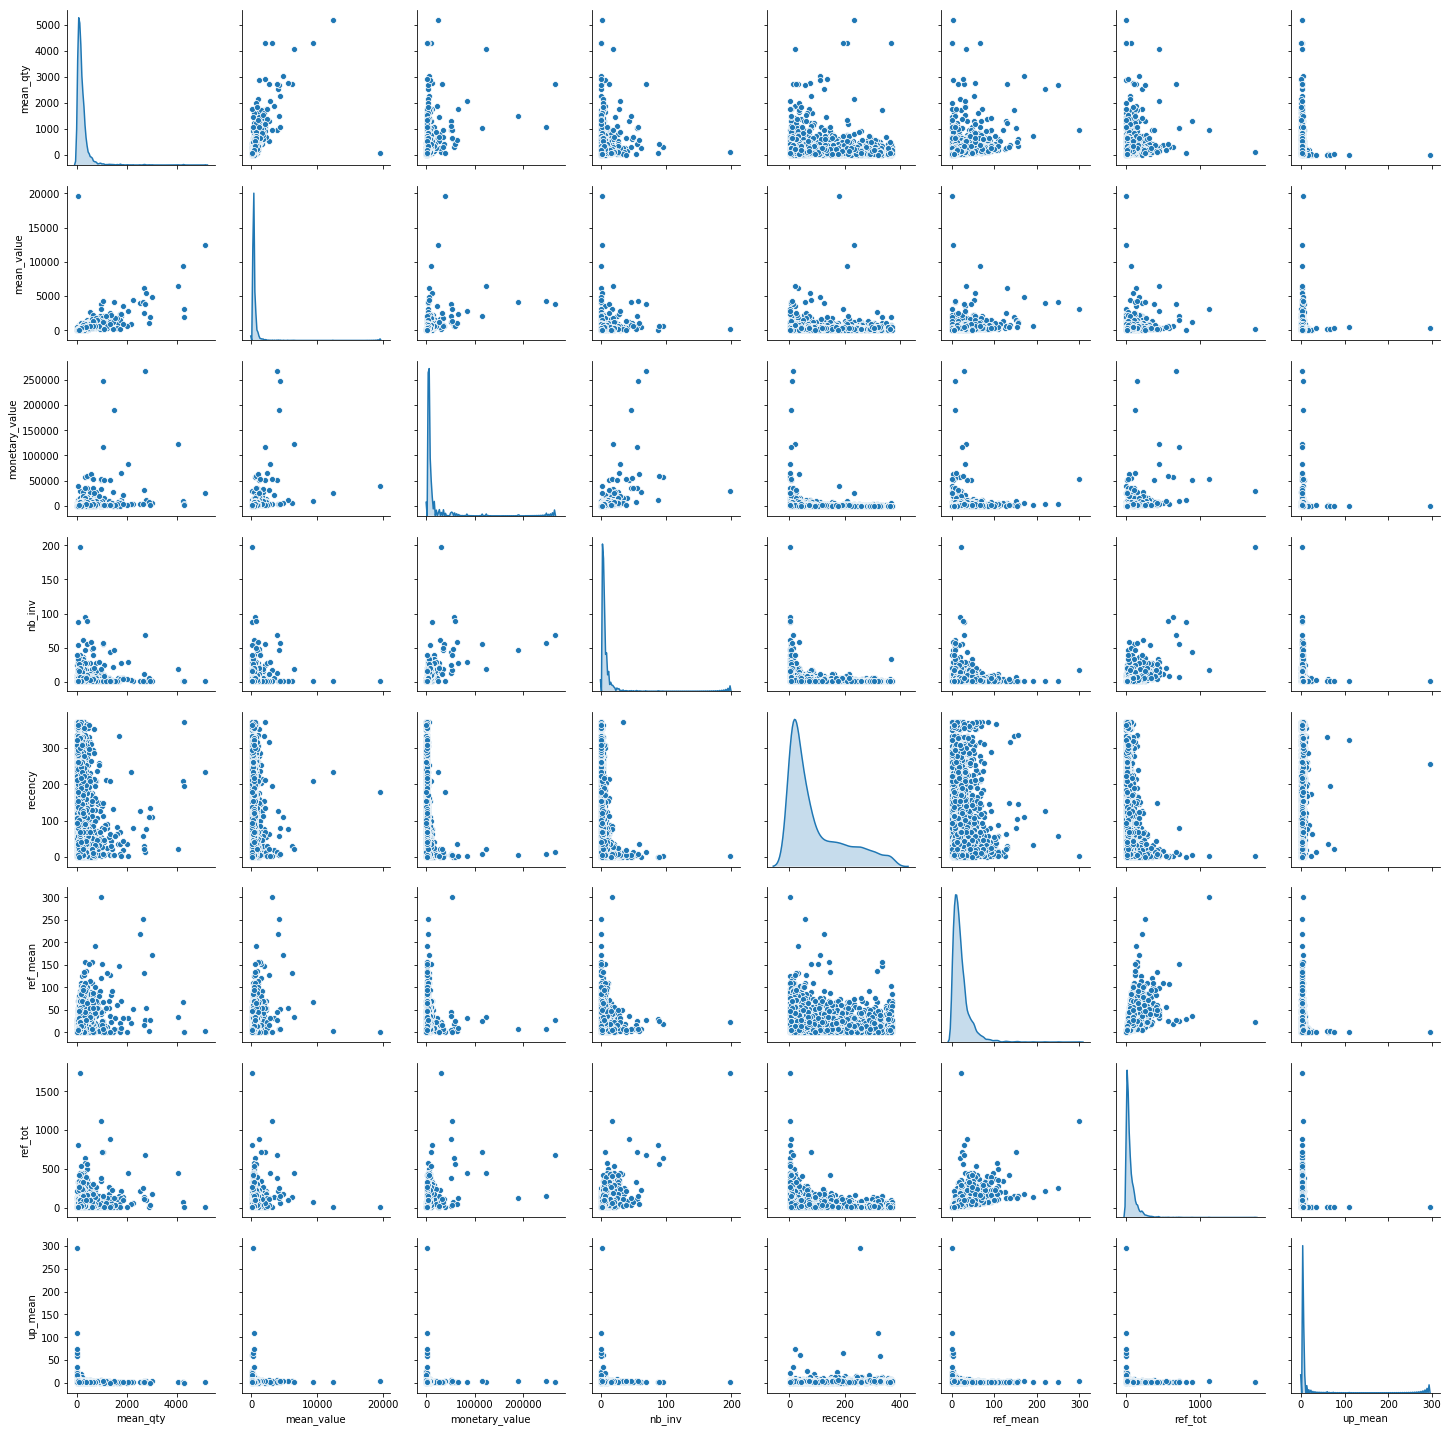

In [101]:
g = sns.pairplot(X, diag_kind="kde")

La matrice de corrélation est la suivante:
(coeff. de Pearson par défaut)

In [0]:
corr_matrix = X.corr()

In [0]:
corr_matrix = round(abs(corr_matrix),2)

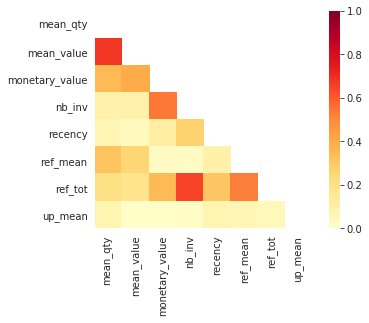

In [104]:

mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr_matrix, mask=mask, vmin=0, vmax=1, square=True,  cmap="YlOrRd")
    plt.show()

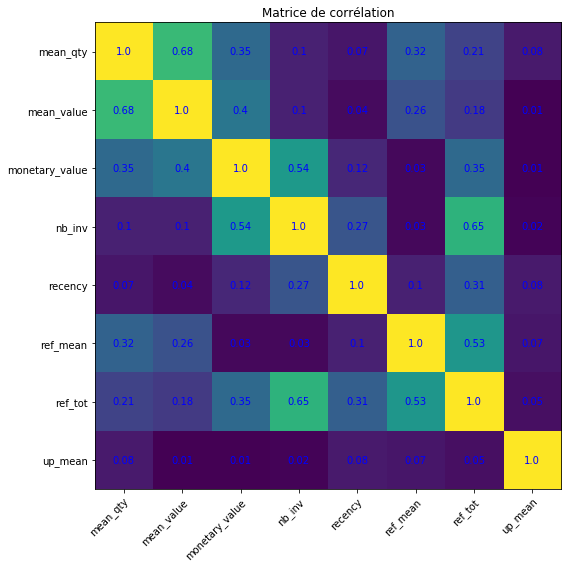

In [105]:
harvest = np.array(corr_matrix)


fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
im = ax.imshow(harvest)

# We want to show all ticks...
sticks_nb = np.arange(len(corr_matrix.columns))
ax.set_xticks(sticks_nb)
ax.set_yticks(sticks_nb)
# ... and label them with the respective list entries
ax.set_xticklabels(corr_matrix.columns)
ax.set_yticklabels(corr_matrix.columns)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in sticks_nb:
    for j in sticks_nb:
        text = ax.text(j, i, harvest[i, j],
                       ha="center", va="center", color="b")

ax.set_title("Matrice de corrélation")
fig.tight_layout()
plt.show()

On peut trouver des valeurs relativement élevée (proches de 0.7) pour les paires:
* mean_qty - mean_value
* nb_inv - ref_tot

Traçons une représentation radar de cette matrice de corrélation.

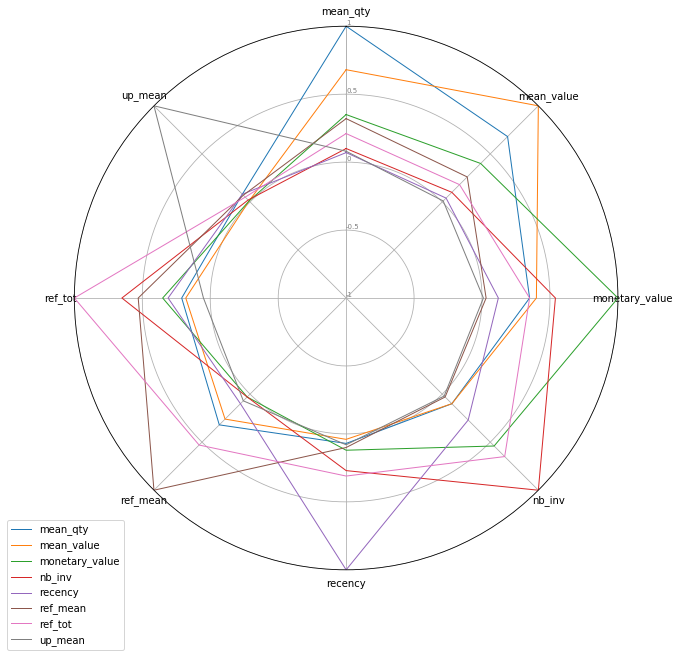

In [106]:
nb_feat = len(corr_matrix.index)
 
 
# ------- PART 1: Create background
 
# number of variable
categories=list(corr_matrix)[:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
# plt.xticks(angles[:-1], categories)
plt.xticks(angles[:], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([-1,-0.5,0,0.5,1], ["-1","-0.5","0","0.5","1"], color="grey", size=7)
plt.ylim(-1,1)
 
 
# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable

for k in range(nb_feat):
  values=corr_matrix.loc[corr_matrix.columns[k]].values.flatten().tolist()
  values += values[:1]
  ax.plot(angles, values, linewidth=1, linestyle='solid', label=corr_matrix.columns[k])

 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))


On constate que mean_value et mean_qty sont corrélées: leurs représentations sont très proches pour toutes les autres variables, et leur coefficient de corrélation élevé.

On peut donc envisager de supprimer mean_value, dont les coefficients de corrélation avec les autres variables sont globalement plus élevés (sur l'extérieur sur le graphe radar).

In [0]:
X.drop(['mean_value'], axis = 1, inplace = True)

### 8.Sauvegarde pour modélisation

In [108]:
data_filename_memmap = os.path.join(folder, 'X_memmap')
dump(X, data_filename_memmap)

['/content/gdrive/My Drive/Colab Notebooks/joblib_memmap/X_memmap']

In [109]:
data_filename_memmap = os.path.join(folder, 'X_train_memmap')
dump(X_train, data_filename_memmap)

['/content/gdrive/My Drive/Colab Notebooks/joblib_memmap/X_train_memmap']

In [110]:
data_filename_memmap = os.path.join(folder, 'X_test_memmap')
dump(X_test, data_filename_memmap)

['/content/gdrive/My Drive/Colab Notebooks/joblib_memmap/X_test_memmap']

In [112]:
data_filename_memmap = os.path.join(folder, 'X_test_new_memmap')
dump(X_test_new, data_filename_memmap)

['/content/gdrive/My Drive/Colab Notebooks/joblib_memmap/X_test_new_memmap']

In [111]:
data_filename_memmap = os.path.join(folder, 't0_memmap')
dump(t_zero, data_filename_memmap)

['/content/gdrive/My Drive/Colab Notebooks/joblib_memmap/t0_memmap']